In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from IPython.core.pylabtools import figsize
from __future__ import print_function

import os
import sys
import glob
import time
import numpy as np
import numpy.random as nr

from keras.preprocessing.image import load_img, img_to_array, array_to_img

from keras.models import Model
from keras.applications import vgg19

from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b
from scipy.ndimage.filters import gaussian_filter

np.set_printoptions(precision=3, linewidth=120, suppress=True)

Using TensorFlow backend.


In [2]:
sys.path.append('../src')
from my_keras_utilities import get_available_gpus
import keras.backend as K
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


<table align='left'>
<tr><td colspan=2> <img src="https://docs.google.com/drawings/d/1BkKZ8truYRIscDmhKpMY_xWYt5o-7mtRwUFbdz92IKs/pub?w=960&h=720"> </td></tr>
</table>


Content image: (1, 400, 499, 3) -123.68 151.061
  Style image: (1, 400, 499, 3) -116.779 131.32


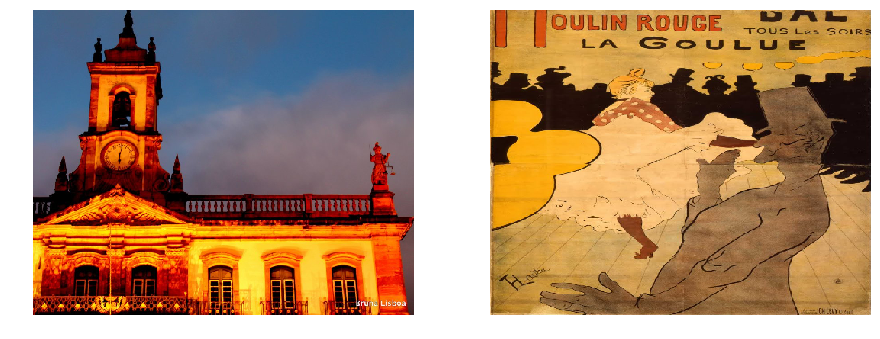

In [3]:
figdir = '../figures/style_transfer/'
resdir = figdir + 'results/'
os.makedirs(resdir, exist_ok=True)

image_file_path = figdir + 'museu_by_bruna.png'
# image_file_path = figdir + 'lavras_novas__bruna.png'

style_file_path = figdir + 'tolouse-lautrec.png'

width, height = load_img(image_file_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(a):
    x = a.copy()
    x = x.reshape(img_nrows, img_ncols, 3)
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

vgg_image = preprocess_image(image_file_path)
vgg_style = preprocess_image(style_file_path)

print('Content image:', vgg_image.shape, vgg_image.min(), vgg_image.max())
print('  Style image:', vgg_style.shape, vgg_style.min(), vgg_style.max())

fig = plot.figure(figsize=(15, 7))
plot.subplot(1, 2, 1)
plot.imshow(deprocess_image(vgg_image[0]))
plot.axis('off')

plot.subplot(1, 2, 2)
plot.imshow(deprocess_image(vgg_style[0]))
plot.axis('off');


In [4]:
vgg = vgg19.VGG19(include_top=False, weights='imagenet', input_shape=vgg_image.shape[1:])
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 499, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 499, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 499, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 249, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 249, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 249, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 124, 128)     0         
__________

In [5]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

def compute_style_loss(output, target): 
    """this "style loss" is designed to maintain
    the style of the reference image in the generated image.
    It is based on the gram matrices (which capture style) of
    feature maps from the style reference image
    and from the generated image"""
    x_gram = gram_matrix(output)
    t_gram = gram_matrix(target)
    return K.mean(K.square(x_gram - t_gram))

def compute_content_loss(output, target):
    """this "content loss" function is
    designed to maintain the "content" of the
    base image in the generated image"""
    return K.mean(K.square(output - target))


class Evaluator(object):
    def __init__(self, fun, shp): 
        self.funct = fun
        self.shape = shp
        
    def get_loss(self, x):
        self.loss, self.grad_values = self.funct([x.reshape(self.shape)])
        return self.loss.astype(np.float64)

    def get_grads(self, x): 
        return self.grad_values.flatten().astype(np.float64)

def my_solver(obj, x, niter=10, prefix=None, interval=1):
    images = []
    try:
        for i in range(niter):
            t0 = time.time()
            x, min_val, info = fmin_l_bfgs_b(obj.get_loss, x.flatten(), fprime=obj.get_grads, maxfun=20)
            dt = time.time() - t0
            if i%interval == 0:
                print('{:2d}. loss: {:.3e} {:.3f}s'.format(i, min_val, dt))
                if prefix is not None:
                    imsave(resdir + prefix + '_at_iteration_{:02d}.png'.format(i), deprocess_image(x))
            images.append(x.copy())
    except KeyboardInterrupt:
        print('Interrupted!!')
    except:
        raise
    finally:
        return images  

In [6]:
vgg_output_dict = {layer.name: layer.output for layer in vgg.layers}

In [7]:
content_weight = 1.0

content_output = vgg_output_dict['block5_conv1']
content_model = Model(vgg.input, content_output)
content_target = K.variable(content_model.predict(vgg_image))
content_loss = content_weight * compute_content_loss(content_output, content_target)

In [8]:
style_weights = [0.2, 0.2, 0.2, 0.2, 0.2]

style_outputs = [vgg_output_dict['block{}_conv1'.format(o)] for o in range(1,6)]
style_model = Model(vgg.input, style_outputs)
style_targets = [K.variable(o) for o in style_model.predict(vgg_style)]
style_loss = sum(w * compute_style_loss(out[0], targ[0]) for out, targ, w in zip(style_outputs, 
                                                                                 style_targets, 
                                                                                 style_weights))

In [9]:
total_loss = content_loss + style_loss

grads = K.gradients(total_loss, vgg.input)
fn = K.function([vgg.input], [total_loss] + grads)

In [10]:
x = np.random.uniform(0.0, 255.0, vgg_image.shape) - 128.0
A = my_solver(Evaluator(fn, vgg_image.shape), x, niter=400, interval=10)

 0. loss: 3.916e+04 9.191s
10. loss: 5.498e+03 7.420s
20. loss: 4.446e+03 7.506s
30. loss: 4.076e+03 7.537s
40. loss: 3.868e+03 7.579s
50. loss: 3.766e+03 7.586s
60. loss: 3.690e+03 7.590s
70. loss: 3.635e+03 7.627s
80. loss: 3.593e+03 7.612s
90. loss: 3.558e+03 7.563s
100. loss: 3.524e+03 7.627s
110. loss: 3.474e+03 7.610s
120. loss: 3.426e+03 7.638s
130. loss: 3.394e+03 7.599s
140. loss: 3.372e+03 7.630s
150. loss: 3.348e+03 7.607s
160. loss: 3.327e+03 7.610s
170. loss: 3.315e+03 7.620s
180. loss: 3.305e+03 7.603s
190. loss: 3.297e+03 7.642s
200. loss: 3.289e+03 7.602s
210. loss: 3.282e+03 7.645s
220. loss: 3.275e+03 7.586s
230. loss: 3.269e+03 7.610s
240. loss: 3.263e+03 7.580s
250. loss: 3.260e+03 7.587s
260. loss: 3.258e+03 7.571s
270. loss: 3.257e+03 7.579s
280. loss: 3.256e+03 7.552s
290. loss: 3.255e+03 7.515s
Interrupted!!


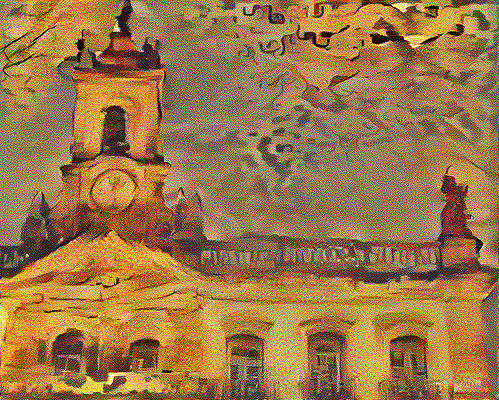

In [11]:
array_to_img(deprocess_image(A[-1]))

In [12]:
A = my_solver(Evaluator(fn, vgg_image.shape), vgg_image, niter=400, interval=10)

 0. loss: 8.822e+03 7.449s
10. loss: 3.627e+03 7.565s
20. loss: 3.382e+03 7.603s
30. loss: 3.291e+03 7.615s
40. loss: 3.241e+03 7.597s
50. loss: 3.214e+03 7.636s
60. loss: 3.197e+03 7.622s
70. loss: 3.184e+03 7.650s
80. loss: 3.175e+03 7.592s
90. loss: 3.167e+03 7.654s
100. loss: 3.159e+03 7.588s
110. loss: 3.153e+03 7.625s
120. loss: 3.148e+03 7.605s
130. loss: 3.145e+03 7.549s
140. loss: 3.143e+03 7.548s
150. loss: 3.142e+03 7.547s
160. loss: 3.140e+03 7.591s
170. loss: 3.140e+03 7.553s
180. loss: 3.139e+03 7.602s
190. loss: 3.138e+03 7.557s
200. loss: 3.137e+03 7.527s
210. loss: 3.137e+03 7.554s
220. loss: 3.137e+03 4.404s
230. loss: 3.137e+03 6.877s
240. loss: 3.137e+03 4.705s
250. loss: 3.137e+03 5.323s
260. loss: 3.137e+03 6.249s
270. loss: 3.137e+03 5.322s
280. loss: 3.137e+03 5.022s
290. loss: 3.137e+03 5.624s
300. loss: 3.137e+03 8.779s
310. loss: 3.137e+03 5.922s
320. loss: 3.137e+03 4.072s
330. loss: 3.137e+03 5.019s
340. loss: 3.137e+03 5.009s
350. loss: 3.137e+03 7.198s
36

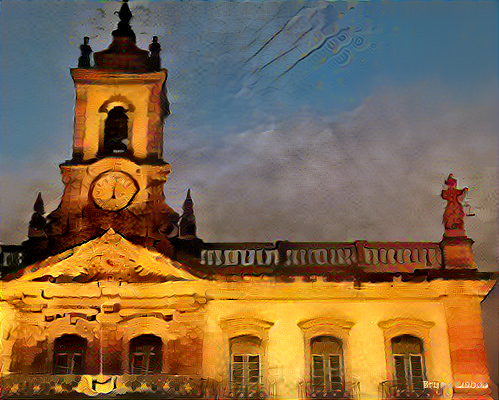

In [13]:
array_to_img(deprocess_image(A[-1]))

In [14]:
x = np.zeros(vgg_image.shape, np.float)
A = my_solver(Evaluator(fn, vgg_image.shape), x, niter=400, interval=10)

 0. loss: 8.769e+04 7.063s
10. loss: 5.750e+03 7.548s
20. loss: 4.593e+03 7.528s
30. loss: 4.172e+03 7.522s
40. loss: 3.957e+03 7.506s
50. loss: 3.826e+03 7.636s
60. loss: 3.743e+03 7.698s
70. loss: 3.687e+03 7.621s
80. loss: 3.645e+03 7.565s
90. loss: 3.615e+03 7.635s
100. loss: 3.587e+03 7.564s
110. loss: 3.557e+03 7.606s
120. loss: 3.531e+03 7.613s
130. loss: 3.512e+03 7.616s
140. loss: 3.492e+03 7.593s
150. loss: 3.476e+03 7.611s
160. loss: 3.465e+03 7.587s
170. loss: 3.458e+03 7.572s
180. loss: 3.452e+03 7.611s
190. loss: 3.447e+03 7.621s
Interrupted!!


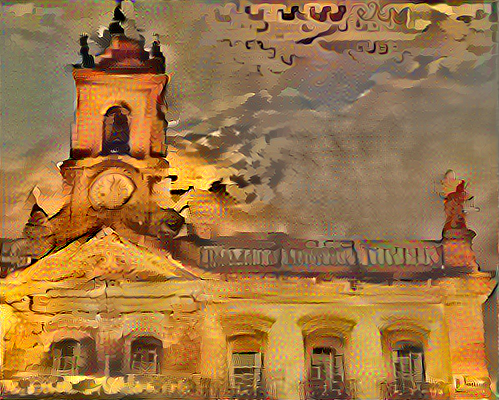

In [15]:
array_to_img(deprocess_image(A[-1]))